In [12]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import functions from qualitative_analysis
from qualitative_analysis.data_processing import load_data, clean_and_normalize, sanitize_dataframe
from qualitative_analysis.model_interaction import get_llm_client
from qualitative_analysis.evaluation import compute_cohens_kappa
from qualitative_analysis.utils import save_results_to_csv, load_results_from_csv
import qualitative_analysis.config as config
from qualitative_analysis.prompt_construction import construct_prompt
from qualitative_analysis.prompt_construction import build_data_format_description
from qualitative_analysis.response_parsing import extract_code_from_response
from qualitative_analysis.cost_estimation import openai_api_calculate_cost


In [13]:
# Define data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [14]:
# Define the path to your dataset
data_file_path = os.path.join(data_dir, 'multiclass_sample.csv')

# Load the data
data = load_data(data_file_path, file_type='csv', delimiter=';')

# Preview the data
data.head()

,index,title,description,protocol,y_true
0,0,inhibition of recombinant human full-length hi...,"title : discovery of sp-96 , the first non-atp...",NaN,-1.0
1,1,inhibition of human intestinal ces2 expressed ...,title : selective inhibitor of human liver car...,NaN,-1.0
2,2,displacement of eu-dtpa-ndp-a-msh chelate from...,title : synthesis and evaluation of bivalent l...,NaN,0.0
3,3,binding affinity at mu opioid receptor 1 in ra...,title : synthesis and biological evaluation of...,NaN,0.0
4,4,inhibition of recombinant solanum lycopersicum...,inhibition of recombinant solanum lycopersicum...,NaN,-1.0


In [15]:
# 1) Define a mapping from old column names to new names
# rename_map = {
#     "ref": "reference",
#     "txt1.ctrl1": "Identify",
#     "txt1.det": "Guess",
#     "txt1.exp": "Seek",
#     "txt1.ctrl2": "Assess"
# }

# # 2) Rename the columns in the DataFrame
# data = data.rename(columns=rename_map)

# 3) Now define the new column names for cleaning
text_columns = ["title", "description"]

# 4) Clean and normalize the new columns
for col in text_columns:
    data[col] = clean_and_normalize(data[col])

# 5) Sanitize the DataFrame
data = sanitize_dataframe(data)


c:\Users\ocler\Documents\Académique\Inria\qualitative_analysis_project\qualitative_analysis\data_processing.py:134: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


In [16]:
# Combine texts and entries

data['verbatim'] = data.apply(
    lambda row: (
        f"Title: {row['title']}\n\n"
        f"Description: {row['description']}"
    ),
    axis=1
)

# Extract the list of verbatims
verbatims = data['verbatim'].tolist()

print(f"Total number of verbatims: {len(verbatims)}")
print(f"Verbatim example:\n{verbatims[0]}")

Total number of verbatims: 94
Verbatim example:
Title: inhibition of recombinant human full-length his-tagged aurora b expressed in baculovirus expression system using 5-fam-lrraslg-conh2 a substrate preincubated for 60 min followed by substrate addition by microfluidic assay

Description: title : discovery of sp-96 , the first non-atp-competitive aurora kinase b inhibitor , for reduced myelosuppression . abstract : aurora kinase b is a serine-threonine kinase known to be overexpressed in several cancer , with no inhibitor approved for clinical use . herein , we present the discovery and optimization of a series of novel quinazoline-based aurora kinase b inhibitor . the lead inhibitor sp-96 show sub-nanomolar potency in aurora b enzymatic assay ( ic = 0.316 ± 0.031 nm ) . we identified the important pharmacophore feature resulting in selectivity against receptor tyrosine kinase . particularly , sp-96 show > 2000 fold selectivity against flt3 and kit which is important for normal hemato

In [17]:
# Choose the provider and model
provider = 'azure'
model_name = 'gpt-4o'

# Initialize the client
llm_client = get_llm_client(provider=provider, config=config.MODEL_CONFIG[provider])

In [18]:
# Define column descriptions
column_descriptions = {
    "Title": "the title of the bioassay",
    "Description": "the description of the bioassay"
}

# Define instructions for multiclass classification
# Instead of a dictionary of multiple themes, we have a single classification scenario
theme_name = "Phenotype Classification"
theme_description = """
The data consists of PubChem bioassays that measure compound activities on proteins.
You must classify the bioassay phenotype into one of the following categories:
- 1: activation (if the bioassay measures the activation of a protein),
- -1: inhibition (if the bioassay measures the inhibition of a protein),
- 0: unclassified (if the activity measured is not clear, or if the bioassay measures both activation and inhibition at the same time).

The phenotype may not be clear in the title alone; please look into the description column to confirm the phenotype.
"""

data_format_description = build_data_format_description(column_descriptions)

# Classification settings
reasoning = False  # If True, perform two-step reasoning. If False, single-step classification.

# Define queries for multiclass classification and reasoning
multiclass_query = "Reply with '1' for activation, '-1' for inhibition, or '0' for unclassified."
reasoning_query = "Generate a one-sentence reasoning about the classification (do not give the classification label)"

# Select subset of verbatims for testing
verbatims_subset = verbatims[:15]

def construct_prompt(verbatim, theme, theme_description):
    """
    Constructs the base prompt for the given verbatim and the multiclass classification scenario.
    """
    prompt = f"""
You are a helpful assistant tasked with evaluating the following entry.

You are provided with data entries in the following format:

{data_format_description}

**Entry:**
{verbatim}

**Task:**
{theme} - {theme_description}
"""
    return prompt.strip()

def generate_with_reasoning(llm_client, model_name, base_prompt, reasoning=False, temperature=0.0001, verbose=False):
    """
    Generates a classification result for multiclass classification.

    If reasoning is False, make one API call:
        Base prompt + multiclass query directly.

    If reasoning is True, make two API calls:
        1) Base prompt + reasoning query (no classification yet).
        2) Base prompt + reasoning answer_from_first_call + multiclass query.
    """
    if reasoning:
        # First call: get reasoning
        first_prompt = f"{base_prompt}\n\n{reasoning_query}"
        print("=== First LLM Prompt (Reasoning) ===")

        response_text_1, usage_1 = llm_client.get_response(
            prompt=first_prompt,
            model=model_name,
            max_tokens=500,
            temperature=temperature,
            verbose=True
        )

        print("\n=== LLM Response (Reasoning) ===")
        print(response_text_1)

        # Second call: use reasoning answer for classification
        second_prompt = f"{base_prompt}\n\nReasoning:\n{response_text_1}\n\n{multiclass_query}"

        print("\n=== Second LLM Prompt (Classification) ===")

        response_text_2, usage_2 = llm_client.get_response(
            prompt=second_prompt,
            model=model_name,
            max_tokens=500,
            temperature=temperature,
            verbose=True
        )

        if verbose:
            print("\n=== LLM Response (Classification) ===")
            print(response_text_2)

        # Combine usage stats
        usage_1.prompt_tokens += usage_2.prompt_tokens
        usage_1.completion_tokens += usage_2.completion_tokens
        usage_1.total_tokens += usage_2.total_tokens

        return response_text_2, usage_1

    else:
        # Single-step classification: base prompt + multiclass query
        single_prompt = base_prompt

        print("=== Single-step Classification Prompt ===")

        response_text, usage = llm_client.get_response(
            prompt=single_prompt,
            model=model_name,
            max_tokens=500,
            temperature=temperature,
            verbose=True
        )
        
        print("\n=== LLM Response (Single-step Classification) ===")
        print(response_text)

        return response_text, usage

# Initialize results and cost tracking
results = []
verbatim_costs = []
total_tokens_used = 0
total_cost = 0

for idx, verbatim in enumerate(verbatims_subset):
    print(f"\n=== Processing Verbatim {idx + 1}/{len(verbatims_subset)} ===")
    verbatim_tokens_used = 0
    verbatim_cost = 0

    print(f"\n--- Evaluating Theme: {theme_name} ---")

    # Build the base prompt
    base_prompt = construct_prompt(
        verbatim=verbatim, 
        theme=theme_name, 
        theme_description=theme_description
    )

    try:
        response_content, usage = generate_with_reasoning(
            llm_client=llm_client,
            model_name=model_name,
            base_prompt=base_prompt,
            reasoning=reasoning,
            temperature=0.0001,
            verbose=True
        )

        # Track token usage
        if usage:
            prompt_tokens = usage.prompt_tokens
            completion_tokens = usage.completion_tokens
            total_tokens = usage.total_tokens

            # Calculate the cost for this request
            cost = openai_api_calculate_cost(usage, model=model_name)
            total_tokens_used += total_tokens
            total_cost += cost
            verbatim_tokens_used += total_tokens
            verbatim_cost += cost

            # Print detailed token usage and cost
            print(f"\nTokens Used: {prompt_tokens} (prompt) + {completion_tokens} (completion) = {total_tokens} total")
            print(f"Cost for '{theme_name}': ${cost:.4f}")

        # Parse response
        # This function should parse the returned text and extract the numerical label (1, 0, or -1)
        # Make sure your `extract_code_from_response` can handle these values.
        score = extract_code_from_response(response_content)
        if score in [1, 0, -1]:
            results.append({
                'Verbatim': verbatim,
                'Label': score
            })
            print(f"Extracted Label: {score}")
        else:
            print("Failed to parse a valid label.")
            results.append({
                'Verbatim': verbatim,
                'Label': None
            })

    except Exception as e:
        print(f"Error processing Verbatim {idx + 1} for '{theme_name}': {e}")
        results.append({
            'Verbatim': verbatim,
            'Label': None
        })

    # Store verbatim-level cost
    verbatim_costs.append({'Verbatim': verbatim, 'Tokens Used': verbatim_tokens_used, 'Cost': verbatim_cost})

# Final Summary
print("\n=== Processing Complete ===")
print(f"Total Tokens Used: {total_tokens_used}")
print(f"Total Cost for Processing: ${total_cost:.4f}")

# Print final multiclass results
for result in results:
    print(result)



=== Processing Verbatim 1/15 ===

--- Evaluating Theme: Phenotype Classification ---
=== Single-step Classification Prompt ===
Prompt:
You are a helpful assistant tasked with evaluating the following entry.

You are provided with data entries in the following format:

The data has the following columns:
- "Title": the title of the bioassay
- "Description": the description of the bioassay


**Entry:**
Title: inhibition of recombinant human full-length his-tagged aurora b expressed in baculovirus expression system using 5-fam-lrraslg-conh2 a substrate preincubated for 60 min followed by substrate addition by microfluidic assay

Description: title : discovery of sp-96 , the first non-atp-competitive aurora kinase b inhibitor , for reduced myelosuppression . abstract : aurora kinase b is a serine-threonine kinase known to be overexpressed in several cancer , with no inhibitor approved for clinical use . herein , we present the discovery and optimization of a series of novel quinazoline-ba

In [8]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Define the save path
outputs_dir = os.path.join(data_dir, 'outputs')
os.makedirs(outputs_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(outputs_dir, f"experiment_{model_name.replace('/', '_')}_{timestamp}.csv")

# Save results
save_results_to_csv(
    coding=results_df.to_dict('records'),
    save_path=save_path,
    fieldnames=['Verbatim', 'Label'],
    verbatims=None  # Verbatims are included in the results
)

Results saved to: data\outputs\experiment_gpt-4o_20241220_135630.csv


In [9]:
# Load results
loaded_results = load_results_from_csv(save_path)
# The function returns (verbatims, coding)
verbatims_loaded, coding_loaded = loaded_results

Results loaded from: data\outputs\experiment_gpt-4o_20241220_135630.csv


In [10]:
# Assuming you have human annotations in the data
human_annotations = data['y_true'].tolist()
human_annotations = [int(x) for x in human_annotations]
model_coding = results_df['Label'].tolist()
model_coding = [int(x) for x in model_coding]

human_annotations_short = human_annotations[:15]

# Compute Cohen's Kappa
kappa = compute_cohens_kappa(
    human_annotations_short,
    model_coding,
    labels=[-1, 0, 1],
    weights='linear'
)

print(f"Cohen's Kappa Score between human annotations and model: {kappa:.2f}")

Cohen's Kappa Score between human annotations and model: 0.00


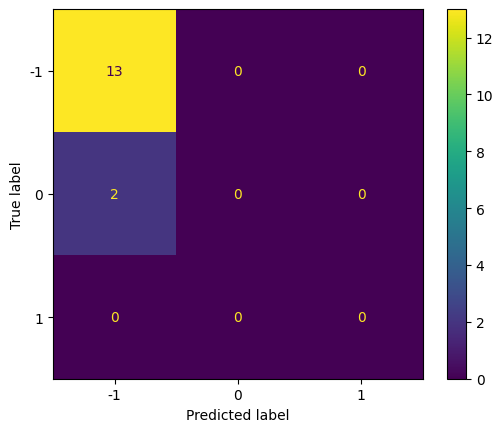

In [11]:
# Confusion Matrix
cm = confusion_matrix(human_annotations_short, model_coding, labels=[-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
disp.plot()
plt.show()